# 🧹 Step 2: Apply Transformations
## Data Loading

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


# Ensure 'transformed' directory exists
os.makedirs("transformed", exist_ok=True)

# Load extracted datasets
raw_df = pd.read_csv("data/raw_data.csv")
incremental_df = pd.read_csv("data/incremental_data.csv")

# Preview to confirm successful loading
print(" Raw Data Loaded:")
display(raw_df.head())

print("\n Incremental Data Loaded:")
display(incremental_df.head())

 Raw Data Loaded:


,order_id,customer_name,product,quantity,unit_price,order_date,region
0,1,Diana,Tablet,NaN,500.0,2024-01-20,South
1,2,Eve,Laptop,NaN,NaN,2024-04-29,North
2,3,Charlie,Laptop,2.0,250.0,2024-01-08,NaN
3,4,Eve,Laptop,2.0,750.0,2024-01-07,West
4,5,Eve,Tablet,3.0,NaN,2024-03-07,South



 Incremental Data Loaded:


,order_id,customer_name,product,quantity,unit_price,order_date,region
0,101,Alice,Laptop,NaN,900.0,2024-05-09,Central
1,102,NaN,Laptop,1.0,300.0,2024-05-07,Central
2,103,NaN,Laptop,1.0,600.0,2024-05-04,Central
3,104,NaN,Tablet,NaN,300.0,2024-05-26,Central
4,105,Heidi,Tablet,2.0,600.0,2024-05-21,North


## Data Exploration and Cleaning

In [4]:
# Data types and missing values
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       100 non-null    int64  
 1   customer_name  99 non-null     object 
 2   product        100 non-null    object 
 3   quantity       74 non-null     float64
 4   unit_price     65 non-null     float64
 5   order_date     99 non-null     object 
 6   region         75 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [5]:
# Duplicate values
raw_df.duplicated().sum()

1

### Explore 'order_id' Column

In [7]:
# Check missing values
raw_df["order_id"].isnull().sum()

0

In [8]:
# Check for duplicates
raw_df["order_id"].duplicated().sum()

1

We have one duplicated value.

Let's see which order_id is duplicate.

In [10]:
raw_df[raw_df["order_id"].duplicated()]

,order_id,customer_name,product,quantity,unit_price,order_date,region
5,4,Eve,Laptop,2.0,750.0,2024-01-07,West


The duplicated value is the order_id '4'.

Since 'order_id' is our unique identifier this is most probably the same record, therefore, we shall drop this row.

In [12]:
raw_df.drop_duplicates(inplace=True)

### Explore 'customer_name' Column

In [14]:
raw_df["customer_name"].isnull().sum()

1

We have one missing value of 'customer_name'.

In [16]:
raw_df["customer_name"].unique()

array(['Diana', 'Eve', 'Charlie', nan, 'Frank', 'Bob', 'Alice'],
      dtype=object)

We will impute the name with 'Anonymous'.

In [18]:
# For customer_name (string column), fill with placeholder
raw_df['customer_name'] = raw_df['customer_name'].fillna('Anonymous')

### Explore 'product' Column

In [20]:
raw_df["product"].isnull().sum()

0

Perfect! no missing values.

In [22]:
raw_df["product"].unique()

array(['Tablet', 'Laptop', 'Monitor', 'Phone'], dtype=object)

The products sold are 'Tablet', 'Laptop', 'Monitor', and 'Phone'.

This column is perfect, but let's make sure the values are consistent using the following code.

In [24]:
# Define allowed product categories
ALLOWED_PRODUCTS = ["Tablet", "Phone", "Computer", "Monitor"]

# Standardize text format (convert to string, strip whitespace, capitalize)
raw_df["product"] = raw_df["product"].astype(str).str.strip().str.title()

# Fix common typos and variants
typo_map = {
    "LapTop": "Laptop",
    "Laptp": "Laptop",
    "Pc": "Computer",
    "DeskTop": "Computer",
    "Mob": "Phone",
    "Smartphone": "Phone",
    "Tab": "Tablet",
    "Moni": "Monitor"
}
raw_df["product"] = raw_df["product"].replace(typo_map)

# Consolidate similar categories
consolidation_map = {
    "Laptop": "Computer",  # Merge laptops into computers
    "Desktop": "Computer",
    "Smart Phone": "Phone"
}
raw_df["product"] = raw_df["product"].replace(consolidation_map)

# Validate against allowed list
raw_df["product"] = np.where(
    raw_df["product"].isin(ALLOWED_PRODUCTS),
    raw_df["product"],
    np.nan  # Replace invalid entries with NaN
)

### Explore 'quantity' Column

In [26]:
raw_df["quantity"].isnull().sum()

26

We have 26 missing values.

As quantity of products ordered depends on the purchasing behaviour of the buyer, we will impute the values by mode of the quantity grouped by customer_name.

In [28]:
raw_df['quantity'].unique()

array([nan,  2.,  3.,  1.])

In [29]:
# Fill missing quantity with the most frequent quantity per customer
raw_df["quantity"] = raw_df.groupby("customer_name")["quantity"].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(1)
)

In [30]:
raw_df['quantity'].unique()

array([1., 2., 3.])

In [31]:
# Quantity to int
raw_df['quantity'] = raw_df['quantity'].astype(int)

### Explore 'unit_price' Column

In [33]:
raw_df["unit_price"].isnull().sum()

35

Our data contains 35 missing values of unit price.

Let's see if each product has a consistent price.

In [35]:
for product in raw_df["product"].unique():
    print("\n", product)
    print(raw_df[raw_df["product"] == product]["unit_price"].value_counts())


 Tablet
unit_price
750.0    10
500.0     8
250.0     7
Name: count, dtype: int64

 Computer
unit_price
250.0    9
500.0    4
750.0    2
Name: count, dtype: int64

 Monitor
unit_price
750.0    6
500.0    6
250.0    4
Name: count, dtype: int64

 Phone
unit_price
750.0    4
250.0    3
500.0    1
Name: count, dtype: int64


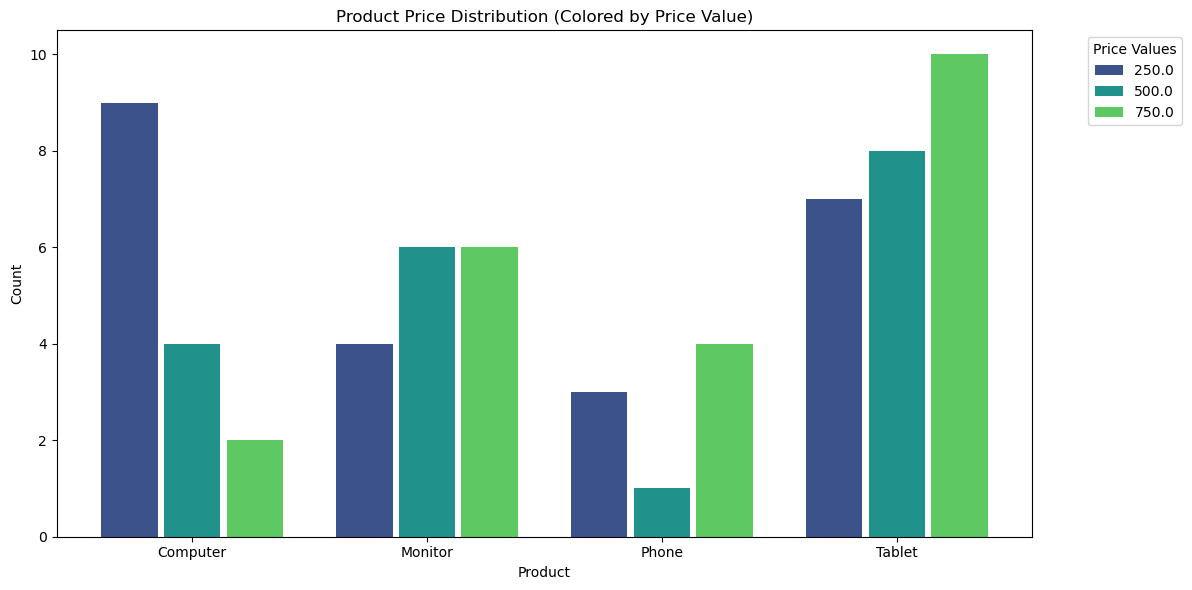

In [36]:
# Prepare data
price_counts = raw_df.groupby(['product', 'unit_price']).size().reset_index(name='count')

# Create figure
plt.figure(figsize=(12, 6))

# Get unique products and create positions
products = price_counts['product'].unique()
max_prices = max(price_counts.groupby('product')['unit_price'].nunique())
bar_width = 0.8 / max_prices  # Dynamic width based on max prices per product

# Create color palette
unique_prices = price_counts['unit_price'].unique()
palette = sns.color_palette("viridis", len(unique_prices))
price_color_map = {price: palette[i] for i, price in enumerate(sorted(unique_prices))}

# Plot each product's prices
for i, product in enumerate(products):
    product_data = price_counts[price_counts['product'] == product]
    
    # Calculate positions for this product's bars
    x_pos = i + np.arange(len(product_data)) * bar_width - (len(product_data)-1)*bar_width/2
    
    for j, (_, row) in enumerate(product_data.iterrows()):
        plt.bar(
            x_pos[j],
            row['count'],
            width=bar_width*0.9,
            color=price_color_map[row['unit_price']],
            label=f"{row['unit_price']}" if i == 0 else ""
        )

# Customize plot
plt.title('Product Price Distribution (Colored by Price Value)')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(np.arange(len(products)), products)
plt.legend(title='Price Values', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Product doesn't seem to help.

Let's see if each product has a fixed price in each region.

In [38]:
for region in raw_df["region"].unique():
    print("\n", region)
    print(raw_df[raw_df["region"] == region].groupby("product")["unit_price"].unique())


 South
product
Computer                  [nan, 250.0]
Monitor                   [nan, 750.0]
Phone                     [nan, 250.0]
Tablet      [500.0, nan, 250.0, 750.0]
Name: unit_price, dtype: object

 North
product
Computer    [nan, 250.0, 500.0]
Monitor                 [500.0]
Phone              [750.0, nan]
Tablet      [nan, 250.0, 750.0]
Name: unit_price, dtype: object

 nan
Series([], Name: unit_price, dtype: float64)

 West
product
Computer           [750.0, nan, 500.0]
Monitor     [750.0, 500.0, 250.0, nan]
Phone              [750.0, 500.0, nan]
Tablet           [750.0, 500.0, 250.0]
Name: unit_price, dtype: object

 East
product
Computer    [250.0, 500.0]
Monitor       [750.0, nan]
Phone                [nan]
Tablet        [750.0, nan]
Name: unit_price, dtype: object


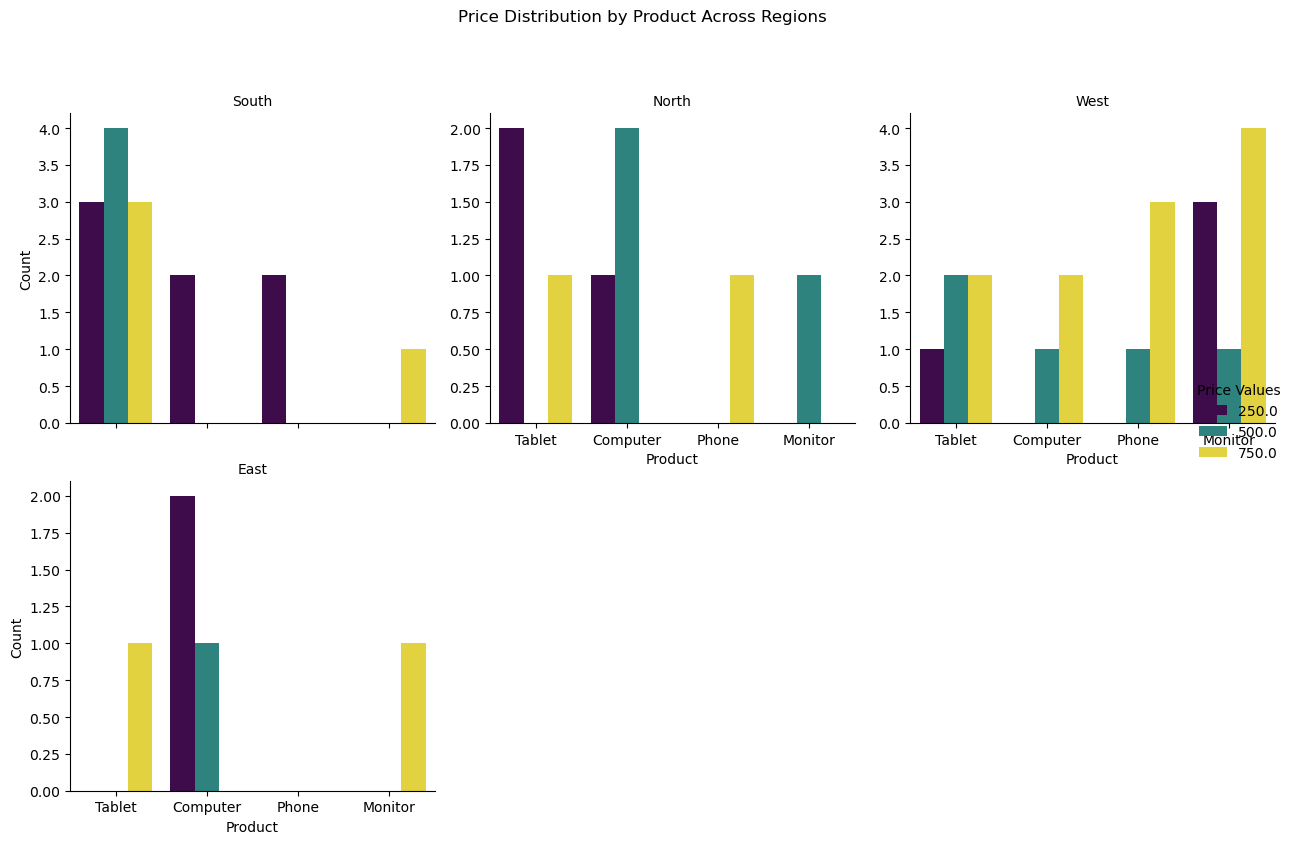

In [39]:
# Prepare the data
price_data = []
for region in raw_df["region"].unique():
    region_df = raw_df[raw_df["region"] == region]
    for product in region_df["product"].unique():
        prices = region_df[region_df["product"] == product]["unit_price"].unique()
        for price in prices:
            if pd.notna(price):
                price_data.append({
                    "Region": region,
                    "Product": product,
                    "Price": price,
                    "Count": len(region_df[(region_df["product"] == product) & 
                                         (region_df["unit_price"] == price)])
                })

price_df = pd.DataFrame(price_data)

# Create visualization
g = sns.FacetGrid(price_df, col="Region", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.barplot, x="Product", y="Count", hue="Price", 
                palette="viridis", dodge=True)
g.add_legend(title="Price Values")
g.set_titles("{col_name}")
g.set_axis_labels("Product", "Count")
g.fig.suptitle("Price Distribution by Product Across Regions", y=1.05)

plt.tight_layout()
plt.show()

From this, we can see that phone, monitor, and laptop has a fixed price in south which means we can impute them with the price of the price of corresponding product sold in south. We can use similar approach to impute phone and monitor in north and monitor and tablet in east.

We can use the global mode of the product to impute the rest.

In [41]:
raw_df["unit_price"].isnull().sum()

35

In [42]:
# For each region-product group, impute NaN if only one unique non-NaN price exists
for region in raw_df["region"].dropna().unique():  # Skip NaN regions
    for product in raw_df["product"].unique():
        # Filter data for the current region-product group
        mask = (raw_df["region"] == region) & (raw_df["product"] == product)
        group_prices = raw_df.loc[mask, "unit_price"]
        
        # Get unique non-NaN prices
        unique_prices = group_prices.dropna().unique()
        
        # If only one unique price exists, impute NaN with that price
        if len(unique_prices) == 1:
            impute_value = unique_prices[0]
            raw_df.loc[mask & (raw_df["unit_price"].isna()), "unit_price"] = impute_value

In [43]:
raw_df["unit_price"].isnull().sum()

23

In [44]:
# For remaining NaNs, impute with the product's global mode price
for product in raw_df["product"].unique():
    product_mode = raw_df[raw_df["product"] == product]["unit_price"].mode()
    if not product_mode.empty:  # Check if mode exists (non-empty)
        mode_price = product_mode[0]
        product_mask = (raw_df["product"] == product) & (raw_df["unit_price"].isna())
        raw_df.loc[product_mask, "unit_price"] = mode_price

In [45]:
raw_df["unit_price"].isnull().sum()

0

### Explore 'order_date' Column

In [47]:
raw_df["order_date"].isnull().sum()

1

There is one missing date.

In [49]:
raw_df[["order_date"]].head(10)

,order_date
0,2024-01-20
1,2024-04-29
2,2024-01-08
3,2024-01-07
4,2024-03-07
6,2024-02-02
7,2024-02-17
8,2024-03-16
9,2024-02-28
10,2024-04-24


As we can see from the output, we don't get a chronologically sorted data if we order the records by the 'order_id' column. If that was the case, we could use forward fill, but for now let's drop it.

In [51]:
# Drop missing date values
raw_df.dropna(subset=["order_date"], inplace=True)

Let's make sure it is in datetime format.

In [53]:
# Convert data types
raw_df['order_date'] = pd.to_datetime(raw_df['order_date'], errors='coerce')

### Explore 'region' Column

In [55]:
raw_df["region"].unique()

array(['South', 'North', nan, 'West', 'East'], dtype=object)

Let's make sure our values are consistent using the following code first.

In [57]:
 # Define allowed regions
ALLOWED_REGIONS = ["North", "South", "West", "East"]

# Standardize text format (convert to string, strip whitespace, capitalize)
raw_df["region"] = raw_df["region"].astype(str).str.strip().str.title()

# Fix common typos and variants
typo_map = {
    "Norh": "North",
    "Soth": "South",
    "Wst": "West",
    "Est": "East",
    "N": "North",
    "S": "South",
    "W": "West", 
    "E": "East"
}
raw_df["region"] = raw_df["region"].replace(typo_map)

# Validate against allowed list
raw_df["region"] = np.where(
    raw_df["region"].isin(ALLOWED_REGIONS),
    raw_df["region"],
    np.nan  # Replace invalid entries with NaN
)

In [58]:
raw_df["region"].isnull().sum()

25

We have 25 missing values of regions.

We will replace the missing values with "Unkown".

In [60]:
# Handle missing values (NaNs) - Impute with 'Unknown'
raw_df["region"] = raw_df["region"].fillna("Unknown")

In [61]:
raw_df["region"].isnull().sum()

0

## Enrichment

We create a 'total_price' column by multiplying 'unit_price' by 'quantity'.

In [64]:
# Enrichment

# Create total_price
raw_df['total_price'] = raw_df['quantity'] * raw_df['unit_price']
raw_df.head(10)

,order_id,customer_name,product,quantity,unit_price,order_date,region,total_price
0,1,Diana,Tablet,1,500.0,2024-01-20,South,500.0
1,2,Eve,Computer,1,250.0,2024-04-29,North,250.0
2,3,Charlie,Computer,2,250.0,2024-01-08,Unknown,500.0
3,4,Eve,Computer,2,750.0,2024-01-07,West,1500.0
4,5,Eve,Tablet,3,750.0,2024-03-07,South,2250.0
6,7,Charlie,Monitor,2,750.0,2024-02-02,West,1500.0
7,8,Charlie,Computer,3,250.0,2024-02-17,Unknown,750.0
8,9,Charlie,Monitor,2,750.0,2024-03-16,West,1500.0
9,10,Eve,Monitor,1,500.0,2024-02-28,North,500.0
10,11,Anonymous,Monitor,3,750.0,2024-04-24,West,2250.0


## Categorizaion

Now, let's categorize the prices into 'Budget', 'Mid-Range', 'Premium', and 'Luxury' based on the following product-specific bins:

**Price Bins Used:**

| Product   | Budget | Mid-Range | Premium | Luxury |
|-----------|--------|-----------|---------|--------|
| Tablet    | 0–299  | 300–599   | 600–899 | 900+   |
| Phone     | 0–499  | 500–799   | 800–1099| 1100+  |
| Computer  | 0–799  | 800–1499  | 1500–2499 | 2500+ |
| Monitor   | 0–199  | 200–399   | 400–599 | 600+   |

In [66]:
# Categorization

# Define product-specific bins and labels
price_bins = {
    'Tablet': [0, 300, 600, 900, float('inf')],
    'Phone': [0, 500, 800, 1100, float('inf')],
    'Computer': [0, 800, 1500, 2500, float('inf')],
    'Monitor': [0, 200, 400, 600, float('inf')]
}

bin_labels = ['Budget', 'Mid-Range', 'Premium', 'Luxury']

# Function to categorize price by product
def categorize_price(row):
    if pd.isna(row['unit_price']):
        return np.nan
    bins = price_bins.get(row['product'], [0, float('inf')])
    return pd.cut(
        [row['unit_price']],
        bins=bins,
        labels=bin_labels,
        right=False
    )[0]

# Apply categorization
raw_df['price_category'] = raw_df.apply(categorize_price, axis=1)

In [67]:
# Define the new column order
new_order = [
'order_id', 
'customer_name', 
'region', 
'product', 
'quantity', 
'unit_price', 
'total_price', 
'price_category', 
'order_date'
]

# Reorder the DataFrame
raw_df = raw_df[new_order]
raw_df.head(10)

,order_id,customer_name,region,product,quantity,unit_price,total_price,price_category,order_date
0,1,Diana,South,Tablet,1,500.0,500.0,Mid-Range,2024-01-20
1,2,Eve,North,Computer,1,250.0,250.0,Budget,2024-04-29
2,3,Charlie,Unknown,Computer,2,250.0,500.0,Budget,2024-01-08
3,4,Eve,West,Computer,2,750.0,1500.0,Budget,2024-01-07
4,5,Eve,South,Tablet,3,750.0,2250.0,Premium,2024-03-07
6,7,Charlie,West,Monitor,2,750.0,1500.0,Luxury,2024-02-02
7,8,Charlie,Unknown,Computer,3,250.0,750.0,Budget,2024-02-17
8,9,Charlie,West,Monitor,2,750.0,1500.0,Luxury,2024-03-16
9,10,Eve,North,Monitor,1,500.0,500.0,Premium,2024-02-28
10,11,Anonymous,West,Monitor,3,750.0,2250.0,Luxury,2024-04-24


# Transformation

In [69]:
def transform(path):

    import pandas as pd
    import numpy as np

    # Load data
    df = pd.read_csv(path)

    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

    # For customer_name (string column), fill with placeholder
    df['customer_name'] = df['customer_name'].fillna('Anonymous')

    # Define allowed product categories
    ALLOWED_PRODUCTS = ["Tablet", "Phone", "Computer", "Monitor"]
    
    # Standardize text format (convert to string, strip whitespace, capitalize)
    df["product"] = df["product"].astype(str).str.strip().str.title()
    
    # Fix common typos and variants
    typo_map = {
        "LapTop": "Laptop",
        "Laptp": "Laptop",
        "Pc": "Computer",
        "DeskTop": "Computer",
        "Mob": "Phone",
        "Smartphone": "Phone",
        "Tab": "Tablet",
        "Moni": "Monitor"
    }
    df["product"] = df["product"].replace(typo_map)
    
    # Consolidate similar categories
    consolidation_map = {
        "Laptop": "Computer",  # Merge laptops into computers
        "Desktop": "Computer",
        "Smart Phone": "Phone"
    }
    df["product"] = df["product"].replace(consolidation_map)
    
    # Validate against allowed list
    df["product"] = np.where(
        df["product"].isin(ALLOWED_PRODUCTS),
        df["product"],
        np.nan  # Replace invalid entries with NaN
    )

    # Fill missing quantity with the most frequent quantity per customer
    df["quantity"] = df.groupby("customer_name")["quantity"].transform(
        lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(1)
    )

    df['quantity'] = df['quantity'].astype(int)

    # For each region-product group, impute NaN if only one unique non-NaN price exists
    for region in df["region"].dropna().unique():  # Skip NaN regions
        for product in df["product"].unique():
            # Filter data for the current region-product group
            mask = (df["region"] == region) & (df["product"] == product)
            group_prices = df.loc[mask, "unit_price"]
            
            # Get unique non-NaN prices
            unique_prices = group_prices.dropna().unique()
            
            # If only one unique price exists, impute NaN with that price
            if len(unique_prices) == 1:
                impute_value = unique_prices[0]
                df.loc[mask & (df["unit_price"].isna()), "unit_price"] = impute_value

    # For remaining NaNs, impute with the product's global mode price
    for product in df["product"].unique():
        product_mode = df[df["product"] == product]["unit_price"].mode()
        if not product_mode.empty:  # Check if mode exists (non-empty)
            mode_price = product_mode[0]
            product_mask = (df["product"] == product) & (df["unit_price"].isna())
            df.loc[product_mask, "unit_price"] = mode_price

    # Convert data types
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

    # Drop missing date values
    df.dropna(subset=["order_date"], inplace=True)

    # Define allowed regions
    ALLOWED_REGIONS = ["North", "South", "West", "East"]
    
    # Standardize text format (convert to string, strip whitespace, capitalize)
    df["region"] = df["region"].astype(str).str.strip().str.title()
    
    # Fix common typos and variants
    typo_map = {
        "Norh": "North",
        "Soth": "South",
        "Wst": "West",
        "Est": "East",
        "N": "North",
        "S": "South",
        "W": "West", 
        "E": "East"
    }
    df["region"] = df["region"].replace(typo_map)
    
    # Validate against allowed list
    df["region"] = np.where(
        df["region"].isin(ALLOWED_REGIONS),
        df["region"],
        np.nan  # Replace invalid entries with NaN
    )

    # 5. Handle missing values (NaNs) - Impute with 'Unknown'
    df["region"] = df["region"].fillna("Unknown")

    # Enrichment
    
    # Create total_price
    df['total_price'] = df['quantity'] * df['unit_price']

    # Categorization

    # Define product-specific bins and labels
    price_bins = {
        'Tablet': [0, 300, 600, 900, float('inf')],
        'Phone': [0, 500, 800, 1100, float('inf')],
        'Computer': [0, 800, 1500, 2500, float('inf')],
        'Monitor': [0, 200, 400, 600, float('inf')]
    }
    
    bin_labels = ['Budget', 'Mid-Range', 'Premium', 'Luxury']
    
    # Function to categorize price by product
    def categorize_price(row):
        if pd.isna(row['unit_price']):
            return np.nan
        bins = price_bins.get(row['product'], [0, float('inf')])
        return pd.cut(
            [row['unit_price']],
            bins=bins,
            labels=bin_labels,
            right=False
        )[0]
    
    # Apply categorization
    df['price_category'] = df.apply(categorize_price, axis=1)

    # Define the new column order
    new_order = [
    'order_id', 
    'customer_name', 
    'region', 
    'product', 
    'quantity', 
    'unit_price', 
    'total_price', 
    'price_category', 
    'order_date'
    ]

    # Reorder the DataFrame
    df = df[new_order]
    
    return df

In [70]:
# Apply transformations
transformed_raw = transform("raw_data.csv")
transformed_incremental = transform("incremental_data.csv")

# Show results
print(" Transformed Full Data Sample:")
display(transformed_raw.head())

print("\n Transformed Incremental Data Sample:")
display(transformed_incremental.head())

# Save transformed datasets
transformed_raw.to_csv("transformed/transformed_full.csv", index=False)
transformed_incremental.to_csv("transformed/transformed_incremental.csv", index=False)

 Transformed Full Data Sample:


,order_id,customer_name,region,product,quantity,unit_price,total_price,price_category,order_date
0,1,Diana,South,Tablet,1,500.0,500.0,Mid-Range,2024-01-20
1,2,Eve,North,Computer,1,250.0,250.0,Budget,2024-04-29
2,3,Charlie,Unknown,Computer,2,250.0,500.0,Budget,2024-01-08
3,4,Eve,West,Computer,2,750.0,1500.0,Budget,2024-01-07
4,5,Eve,South,Tablet,3,750.0,2250.0,Premium,2024-03-07



 Transformed Incremental Data Sample:


,order_id,customer_name,region,product,quantity,unit_price,total_price,price_category,order_date
0,101,Alice,Unknown,Computer,1,900.0,900.0,Mid-Range,2024-05-09
1,102,Anonymous,Unknown,Computer,1,300.0,300.0,Budget,2024-05-07
2,103,Anonymous,Unknown,Computer,1,600.0,600.0,Budget,2024-05-04
3,104,Anonymous,Unknown,Tablet,1,300.0,300.0,Mid-Range,2024-05-26
4,105,Heidi,North,Tablet,2,600.0,1200.0,Premium,2024-05-21


In [71]:
# Observations
print("\nObservations:")
print(f"- transformed_raw has {transformed_raw.isnull().sum().sum()} missing values.")
print(f"- transformed_incremental has {transformed_incremental.isnull().sum().sum()} missing values.")
print(f"- transformed_raw has {transformed_raw.duplicated().sum()} duplicate rows.")
print(f"- transformed_incremental has {transformed_incremental.duplicated().sum()} duplicate rows.")


Observations:
- transformed_raw has 0 missing values.
- transformed_incremental has 0 missing values.
- transformed_raw has 0 duplicate rows.
- transformed_incremental has 0 duplicate rows.


In [72]:
def validate_transformed_data(path):
    print(f"🔍 Validating: {path}\n")
    
    # Load the dataset
    df = pd.read_csv(path)
    
    # 1. Shape
    print(f"✅ Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
    
    # 2. Column Names and Data Types
    print("📋 Columns and Data Types:")
    print(df.dtypes)
    print()
    
    # 3. Missing Values
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("✅ No missing values detected.\n")
    else:
        print("⚠️ Missing Values Detected:")
        print(missing[missing > 0])
        print()
    
    # 4. Duplicate Rows
    num_duplicates = df.duplicated().sum()
    print(f"🧾 Duplicate Rows: {num_duplicates}\n")
    
    # 5. Value Checks
    print("🔎 Sample Unique Values:")
    for col in ['product', 'region', 'price_category']:
        if col in df.columns:
            print(f"- {col}: {df[col].dropna().unique()}")
    print()

    # 6. Date Format Check
    if 'order_date' in df.columns:
        try:
            pd.to_datetime(df['order_date'])
            print("✅ order_date column is valid datetime format.\n")
        except Exception as e:
            print("❌ order_date format issue:", e, "\n")
    
    # 7. Price and Quantity Checks
    if 'total_price' in df.columns and 'quantity' in df.columns and 'unit_price' in df.columns:
        test_calc = df['quantity'] * df['unit_price']
        if (abs(test_calc - df['total_price']) < 0.01).all():
            print("✅ total_price values are consistent with quantity × unit_price.\n")
        else:
            print("❌ Inconsistent total_price values.\n")
    
    print("✅ Validation complete.\n")


# Run the test on both transformed datasets
validate_transformed_data("transformed/transformed_full.csv")
validate_transformed_data("transformed/transformed_incremental.csv")

🔍 Validating: transformed/transformed_full.csv

✅ Shape: 98 rows × 9 columns

📋 Columns and Data Types:
order_id            int64
customer_name      object
region             object
product            object
quantity            int64
unit_price        float64
total_price       float64
price_category     object
order_date         object
dtype: object

✅ No missing values detected.

🧾 Duplicate Rows: 0

🔎 Sample Unique Values:
- product: ['Tablet' 'Computer' 'Monitor' 'Phone']
- region: ['South' 'North' 'Unknown' 'West' 'East']
- price_category: ['Mid-Range' 'Budget' 'Premium' 'Luxury']

✅ order_date column is valid datetime format.

✅ total_price values are consistent with quantity × unit_price.

✅ Validation complete.

🔍 Validating: transformed/transformed_incremental.csv

✅ Shape: 10 rows × 9 columns

📋 Columns and Data Types:
order_id            int64
customer_name      object
region             object
product            object
quantity            int64
unit_price        float64
tota